# SentiStrength Analysis
### with new sentiment lists for word forms and lemmas, emoticons and emojis
### for 'corrected' text samples

This python script below uses SentiStrength to classify the sentiment of each line of a text file in pandas dataframes.

### This script was published as a part of research work
This script was created and published by Merja Kreivi-Kauppinen, and it is part of research work carried at University of Oulu in 2020-2023. Topic of research work and thesis: 'Signs of Paradigm Shift in Hate Speech Detection Methodology: Hate Speech Detection of Dialectal, Granular and Urban Finnish'

### Method of sentiment analysis (SA) with SentiStrength

Binary, trinary, and polarity (multilabel) sentiment classification of social media text samples with SentiStrength SA were carried on tokenized or lemmatized text samples, where words, emoticons and emojis were used to get sentiment scoring.

Emoticons and emojis were taken into account in sentiment scoring.

SA with SentiStrength was carried in three separate processes: 
- (1) binary SA, 
- (2) trinary SA, and 
- (3) (multilabel) polarity SA.

Scoring was carried for 'raw' or manually 'corrected' text samples on separate processes.

Samples were preprpcessed with two steps:

- (1) Text samples were lemmatized with experimental Finnish Voikko method designed for Spacy (Spacy version 3.5.0) using large Finnish language model 'fi_core_news_lg' the source of tokens. Text samples were further tokenized with NLTK casual tokenization method, and set to lower capitals before feeding to SentiStrength scoring process.

- (2) Emojis of text samples were changed to english word forms before SentiStrength scoring.

Results were analyzed with methods of scikit-learn library by calculating confusion matrix, and accuracy, F1, precision and recall scores for tested classifiers.

### The original SentiStrength publicly available

Original version of SentiStrength method available at: 

http://sentistrength.wlv.ac.uk/#Download

References: 

 - Thelwall, M., Buckley, K., Paltoglou, G. Cai, D., & Kappas, A. (2010). Sentiment strength detection in short informal text. Journal of the American Society for Information Science and Technology, 61(12), 2544–2558.

 - Thelwall, M., Buckley, K., & Paltoglou, G. (2012). Sentiment strength detection for the social Web, Journal of the American Society for Information Science and Technology, 63(1), 163-173.
 
 - Thelwall, M., Buckley, K., & Paltoglou, G. (2011). Sentiment in Twitter events. Journal of the American Society for Information Science and Technology, 62(2), 406-418.

### Improved new lexicons for SentiStrength (in Finnish)

The modified SentiStrength (for Finnish social media text samples) use new Finnish SentiStrength lexicons for sentiment classification. Finnish SentiStrength for classification of Finnish text uses lexicon which includes basic, pended, subword and lemma forms of words and their polarity labels. All lexicons (words, emoticons, emojis) were provided on lexicographically descending order to enable more precise text, emoticon, symbol, and emoji matching.

- EmotionLookupTable - On (word based sentiment) emotion lexicon 'EmotionLookupTable.txt' each word is labeled with one sentiment label (between -5 and 5). New 'EmotionLookupTable' (for Finnish) includes 11512 word forms.

- EmoticonLookupTable - On emoticon and emoji lexicon 'EmoticonLookupTable.txt' each emoticon and emoji is labeled with one sentiment label (between -5 and 5). New 'EmoticonLookupTable' includes 527 emoticons and 613 emojis.

- IdiomLookupTable - On idiom lexicon 'IdiomLookupTable.txt' each idiom is labeled with one sentiment label (between -5 and 5). New 'IdiomLookupTable' (for Finnish) includes 353 entries.

- NegatingWordList - On negating word lexicon 'NegatingWordList.txt' each entry is labeled with one sentiment label (between -5 and 5). New 'NegatingWordList' (for Finnish) includes 37 entries.

- QuestionWords - On question words lexicon 'QuestionWords.txt' each entry is labeled with one sentiment label (between -5 and 5). New 'QuestionWords' (for Finnish) includes 19 entries.

- BoosterWordList - On booster words lexicon 'BoosterWordList.txt' each entry is labeled with one sentiment label (between -5 and 5). 'BoosterWordList' (for Finnish) includes 20 entries.

New modified (and old unmodified) lexicons for Finnish SentiStrength models are available at 'Finnish_SentiStrength' -folder. All experiments with SentiStrength -models were carried with lexicons mentioned above. The folder was added on the wheel of SentiStrength -methods as 'SentiStrength_FIN' -folder.


### Installation and Set Up

All experiments with SentiStrength -models were carried with lexicons mentioned above. The folder was added on the wheel of SentiStrength -methods as 'SentiStrength_FIN' -folder.

### Import and check  jupyter python installations, packages, and libraries

In [1]:
# import python packages and libraries
import subprocess
import shlex
import os.path

import sys, re, os
import numpy as np
import pandas as pd

import string, math 
import time, datetime, random

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import casual_tokenize, word_tokenize, sent_tokenize, WhitespaceTokenizer

import emoji
from emoji import *
import functools
import operator

The scikit-learn version is 1.1.2.


# Import Experimental Spacy and Voikko

In [2]:
# Import and check Spacy
import spacy
print(f"Spacy Version: {spacy.__version__}")

# Load large Finnish model for spacy
FinSpacyLarge = spacy.load("fi_core_news_lg")

# Test large Finnish model
doc = FinSpacyLarge('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

Spacy Version: 3.5.0
terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	NOUN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
Ilmassa	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
Rännit	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juoksevat	VERB
.	PUNCT


In [3]:
from libvoikko import Voikko
print("\nCurrent working directory " , os.getcwd())

# set up Voikko search path for Voikko help
Voikko.setLibrarySearchPath("c:/Voikko")
help(Voikko)


Current working directory  C:\Users\merja\Desktop\HS_research_project\sentistrength
Help on class Voikko in module libvoikko:

class Voikko(builtins.object)
 |  Voikko(language, path=None)
 |  
 |  Represents an instance of Voikko. The instance has state, such as
 |  settings related to spell checking and hyphenation, and methods for performing
 |  various natural language analysis operations. One instance should not be
 |  used simultaneously from multiple threads.
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __init__(self, language, path=None)
 |      Creates a new Voikko instance with the following optional parameters:
 |      language  BCP 47 language tag to be used.
 |      path      Extra path that will be checked first when looking for linguistic
 |                resources.
 |  
 |  analyze(self, word)
 |      Analyze the morphology of given word and return the list of
 |      analysis results. The results are represented as maps having property
 |      names

In [4]:
# get Voikko directory list
print("\nVoikko directory list:  ", Voikko.listDicts("C:/Voikko"))

# get Voikko version
print("Voikko version:  ", Voikko.getVersion())


Voikko directory list:   [<fi,,standard,suomi (perussanasto)>, <fi,,dialects,suomi (murteellisten, vanhojen ja harvinaisten sanojen sanasto)>, <fi,,education,suomi (kasvatustieteen sanasto)>, <fi,,medicine,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian ja lääketieteen sanastot)>, <fi,,morpho,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio)>, <fi,,morphoid,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio ja linkitys Joukahaiseen)>, <fi,,po,suomi (po-tiedostojen oikolukusanasto)>, <fi,,science,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian, lääketieteen, kasvatustieteen ja tietotekniikan sanastot)>]
Voikko version:   4.3


In [5]:
# Test experimental Finnish Spacy model with Spacy

# Load experimental Finnish Spacy
FinSpacyExp = spacy.load("spacy_fi_experimental_web_md")

# Test the model
doc = FinSpacyExp('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	PROPN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
ilma	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
ränni	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juosta	VERB
.	PUNCT


### Download labeled HS data

In [6]:
# Download labeled HS data from xlsx file to pd dataFolder

cwd = os.getcwd()
folder = '\\data\\'
csv_file = 'Manually_Annotated_Collection_ALL_FINAL_22023Merja.xlsx'
csv_source = cwd + folder + csv_file
#print(csv_source)
df = pd.read_excel(csv_source)
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,negative,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",negative,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria
2,3,--´973´¤-.ttu,negative,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria
3,4,-=>Widdu joo<=-,negative,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",negative,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,False,0,NaN,NaN,NaN,JOY,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,😂😂😂😂😂,Meria
6625,6626,😠👉👩‍💼,negative,-3,False,0,NaN,NaN,NaN,ANGER HATE,😠👉👩‍💼,😠👉👩‍💼,Meria
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,False,0,NaN,NaN,NaN,JOY,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,Meria
6627,6628,🤮😡,negative,-4,False,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",🤮😡,🤮😡,Meria


In [7]:
# Change text samples to string
df["stringSample"] = df[str("sample")]
df["stringCorrect"] = df[str("correct_finnish")]

# add string len column
df["stringLength"] = ""

# extract string length measures of data
def extract_stringLen(df):
    for item in df["stringCorrect"]:
        df["stringLength"] = df.stringCorrect.str.len()
    return df

extract_stringLen(df)
df.head(10)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,negative,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",negative,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria,"- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",984
2,3,--´973´¤-.ttu,negative,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria,--´973´¤-.ttu,973 vittu,9
3,4,-=>Widdu joo<=-,negative,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria,-=>Widdu joo<=-,-=> vittu joo <=-,17
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",negative,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria,"- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",144
5,6,- ei viddu -,negative,-5,True,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,ei viddu,ei vittu,Meria,- ei viddu -,ei vittu,8
6,7,- Huvittunut -,positive,1,False,0,NaN,NaN,NaN,JOY,Huvittunut,huvittunut,Meria,- Huvittunut -,huvittunut,10
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",negative,-4,True,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL","- Hyvä että JOKU näkee uuden , tyhmän veroperu...","Hyvä että JOKU näkee uuden, tyhmän veroperuste...",Meria,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...","Hyvä että JOKU näkee uuden, tyhmän veroperuste...",124
8,9,- Kukaan luterilainen ei korota itseään hänen ...,negative,-2,False,0,NaN,NaN,NaN,SADNESS,- Kukaan luterilainen ei korota itseään hänen ...,Kukaan luterilainen ei korota itseään hänen su...,Meria,- Kukaan luterilainen ei korota itseään hänen ...,Kukaan luterilainen ei korota itseään hänen su...,105
9,10,- kuten on sovittu -,neutral,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,- kuten on sovittu -,kuten on sovittu,Meria,- kuten on sovittu -,kuten on sovittu,16


In [8]:
# change sentiment values
df['sentiment'] = df['sentiment'].replace('neutral', 0)
df['sentiment'] = df['sentiment'].replace('positive', 1)
df['sentiment'] = df['sentiment'].replace('negative', -1)

# change HS / not HS values
df['HSbinary'] = df['HSbinary'].replace(False, 0)
df['HSbinary'] = df['HSbinary'].replace(True, 1)
df.tail(10)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength
6619,6620,👎😠,-1,-3,0,0,NaN,NaN,NaN,"UNPLEASENT, ANGER HATE",👎😠,👎😠,Meria,👎😠,👎😠,2
6620,6621,💖,1,3,0,0,NaN,NaN,NaN,HAPPINESS,💖,💖,Meria,💖,💖,1
6621,6622,😂,1,2,0,0,NaN,NaN,NaN,JOY,😂,😂,Meria,😂,😂,1
6622,6623,😂 ai kauhee. Ei oo hauska asia jos itelle tapa...,-1,-4,0,0,NaN,NaN,NaN,SURPRISE,😂 ai kauhee. Ei oo hauska asia jos itelle tapa...,😂 ai kauhee. Ei oo hauska asia jos itelle tapa...,Meria,😂 ai kauhee. Ei oo hauska asia jos itelle tapa...,😂 ai kauhee. Ei oo hauska asia jos itelle tapa...,81
6623,6624,😂😂😂😂😂😂,1,5,0,0,NaN,NaN,NaN,JOY,😂😂😂😂😂😂,😂😂😂😂😂😂,Meria,😂😂😂😂😂😂,😂😂😂😂😂😂,6
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,5,0,0,NaN,NaN,NaN,JOY,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,😂😂😂😂😂,Meria,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,😂😂😂😂😂,5
6625,6626,😠👉👩‍💼,-1,-3,0,0,NaN,NaN,NaN,ANGER HATE,😠👉👩‍💼,😠👉👩‍💼,Meria,😠👉👩‍💼,😠👉👩‍💼,5
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,5,0,0,NaN,NaN,NaN,JOY,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,Meria,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
6627,6628,🤮😡,-1,-4,0,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",🤮😡,🤮😡,Meria,🤮😡,🤮😡,2
6628,6629,🦋💜,1,4,0,0,NaN,NaN,NaN,"JOY, HAPPINESS",🦋💜,🦋💜,Meria,🦋💜,🦋💜,2


In [9]:
# Lemmatization of raw samples
df['sampleLemmas'] = df['stringSample'].apply(lambda row: " ".join([token.lemma_ for token in FinSpacyExp(row)]))

# Lemmatization of corrected samples
df['correctLemmas'] = df['stringCorrect'].apply(lambda row: " ".join([token.lemma_ for token in FinSpacyExp(row)]))

df.tail(20)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength,sampleLemmas,correctLemmas
6609,6610,ÖÖ T:VITTU,-1,-4,1,2,NONE,TROLLING,SWEARING,"SURPRISE, CONTEMPT DISRESPECT",ÖÖ T:VITTU,ÖÖ T: VITTU,Meria,ÖÖ T:VITTU,ÖÖ T: VITTU,11,ÖÖ T:VITTU,öö T : Vittu
6610,6611,ÖÖ7jaKuolemanKurvit,-1,-2,0,0,NaN,NaN,NaN,"DISGUST, SARCASTIC",ÖÖ7 ja Kuoleman Kurvit,007 ja kuoleman kurvit,Meria,ÖÖ7jaKuolemanKurvit,007 ja kuoleman kurvit,22,öö7jakuolemankurvit,007 ja kuolema kurvi
6611,6612,ööliä vittu,-1,-4,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",CONTEMPT DISRESPECT,ööliä vittu,olutta vittu,Meria,ööliä vittu,olutta vittu,12,ööliä vittu,olut vittu
6612,6613,öö-luokkalaiset.vittuun,-1,-5,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING",SARCASTIC,öö-luokkalaiset vittuun,öö-luokkalaiset vittuun,Meria,öö-luokkalaiset.vittuun,öö-luokkalaiset vittuun,23,öö-luokkalaiset.vittuun,öö-luokkalaiset vittu
6613,6614,öö-vittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",DISGUST,öö -vittu,öö vittu,Meria,öö-vittu,öö vittu,8,öö-vittu,öö vittu
6614,6615,ööö,-1,-1,0,0,NaN,NaN,NaN,UNPLEASENT,ööö,ööö,Meria,ööö,ööö,3,ööö,ööö
6615,6616,Ööö mitä vittua??,-1,-4,1,2,NONE,OPINION,"JOKE SARCASM, SWEARING",SURPRISE,Ööö mitä vittua??,"Öö, mitä vittua??",Meria,Ööö mitä vittua??,"Öö, mitä vittua??",17,Ööö mitä vittu ? ?,"Öö , mitä vittu ? ?"
6616,6617,Ööövittuentiiä,-1,-5,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",CONTEMPT DISRESPECT,Ööö vittu en tiiä,Öö vittu en tiedä,Meria,Ööövittuentiiä,Öö vittu en tiedä,17,ööövittuentiiä,Öö vittu ei tietää
6617,6618,"👍❤Hyvä Ville, sinua on ilo kuunnella, nautin a...",1,5,0,0,NaN,NaN,NaN,"JOY, HAPPINESS, TRUST","👍❤Hyvä Ville, sinua on ilo kuunnella, nautin a...","👍❤Hyvä Ville, sinua on ilo kuunnella, nautin a...",Meria,"👍❤Hyvä Ville, sinua on ilo kuunnella, nautin a...","👍❤Hyvä Ville, sinua on ilo kuunnella, nautin a...",101,"👍 ❤ hyvä Ville , sinä olla ilo kuunnella , nau...","👍 ❤ hyvä Ville , sinä olla ilo kuunnella , nau..."
6618,6619,👍🏻,1,1,0,0,NaN,NaN,NaN,HAPPINESS,👍🏻,👍🏻,Meria,👍🏻,👍🏻,2,👍 🏻,👍 🏻


In [10]:
# Lower text
df['sample_tokens'] = df['sampleLemmas'].apply(lambda row: row.lower())
# Lower text
df['correct_tokens'] = df['correctLemmas'].apply(lambda row: row.lower())
df.tail(40)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength,sampleLemmas,correctLemmas,sample_tokens,correct_tokens
6589,6590,äärimmäisen vittuuntunut.,-1,-5,1,1,NONE,OPINION,SWEARING,ANGER HATE,äärimmäisen vittuuntunut.,äärimmäisen vittuuntunut,Meria,äärimmäisen vittuuntunut.,äärimmäisen vittuuntunut,24,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut
6590,6591,äärivassarit vittuun,-1,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,äärivassarit vittuun,äärivassarit vittuun,Meria,äärivassarit vittuun,äärivassarit vittuun,20,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu
6591,6592,Ääs-viduilija,-1,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,Ääs vittuilija,perse vittuilija,Meria,Ääs-viduilija,perse vittuilija,16,ääs-viduilija,perse vittuilija,ääs-viduilija,perse vittuilija
6592,6593,äää vittu mikä räkis,-1,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",äää vittu mikä räkis,äh vittu mikä rääkki,Meria,äää vittu mikä räkis,äh vittu mikä rääkki,20,äää vittu mikä räkis,äh vittu mikä rääkki,äää vittu mikä räkis,äh vittu mikä rääkki
6593,6594,Äääärimamuttajat,-1,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,Ääääri mamuttajat,äärimamuttajat,Meria,Äääärimamuttajat,äärimamuttajat,14,äääärimamuttajat,äärimamuttajat,äääärimamuttajat,äärimamuttajat
6594,6595,äääää...vittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",äääää ... vittu,äh… vittu,Meria,äääää...vittu,äh… vittu,9,äääää ... vittu,äh … vittu,äääää ... vittu,äh … vittu
6595,6596,äääääähläm,-1,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,äääää ähläm,ähläm,Meria,äääääähläm,ähläm,5,äääääähläm,ähläm,äääääähläm,ähläm
6596,6597,öbkibvbvittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,öbkibvb vittu,öbkibvb vittu,Meria,öbkibvbvittu,öbkibvb vittu,13,öbkibvbvittu,öbkibvb vittu,öbkibvbvittu,öbkibvb vittu
6597,6598,öitääääääää!😴😴,0,1,0,0,NaN,NaN,NaN,NEUTRAL NONE,öitääääääää! 😴 😴,öitä! 😴 😴,Meria,öitääääääää!😴😴,öitä! 😴 😴,9,öitääääääää ! 😴 😴,yö ! 😴 😴,öitääääääää ! 😴 😴,yö ! 😴 😴
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,Ökyrikkaat KURIIN vittu,ökyrikkaat kuriin vittu,Meria,ÖkyrikkaatKURIINvittu,ökyrikkaat kuriin vittu,23,ÖkyrikkaatKURIINvittu,ökyrikas kuri vittu,ökyrikkaatkuriinvittu,ökyrikas kuri vittu


In [11]:
# Get emoji names for raw samples
df['sampleEmojis'] = df['sample_tokens'].apply(lambda row: emoji.demojize(row))
#df['sampleEmojis'] = df['sample_tokens'].apply(lambda row: [emoji.demojize(token) for token in row])

# Get emoji names for corrected samples
df['correctEmojis'] = df['correct_tokens'].apply(lambda row: emoji.demojize(row))
#df['correctEmojis'] = df['correct_tokens'].apply(lambda row: [emoji.demojize(token) for token in row])
#df
df.tail(40)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,user_nick,stringSample,stringCorrect,stringLength,sampleLemmas,correctLemmas,sample_tokens,correct_tokens,sampleEmojis,correctEmojis
6589,6590,äärimmäisen vittuuntunut.,-1,-5,1,1,NONE,OPINION,SWEARING,ANGER HATE,...,Meria,äärimmäisen vittuuntunut.,äärimmäisen vittuuntunut,24,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut
6590,6591,äärivassarit vittuun,-1,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,...,Meria,äärivassarit vittuun,äärivassarit vittuun,20,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu
6591,6592,Ääs-viduilija,-1,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,...,Meria,Ääs-viduilija,perse vittuilija,16,ääs-viduilija,perse vittuilija,ääs-viduilija,perse vittuilija,ääs-viduilija,perse vittuilija
6592,6593,äää vittu mikä räkis,-1,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,Meria,äää vittu mikä räkis,äh vittu mikä rääkki,20,äää vittu mikä räkis,äh vittu mikä rääkki,äää vittu mikä räkis,äh vittu mikä rääkki,äää vittu mikä räkis,äh vittu mikä rääkki
6593,6594,Äääärimamuttajat,-1,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,...,Meria,Äääärimamuttajat,äärimamuttajat,14,äääärimamuttajat,äärimamuttajat,äääärimamuttajat,äärimamuttajat,äääärimamuttajat,äärimamuttajat
6594,6595,äääää...vittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,Meria,äääää...vittu,äh… vittu,9,äääää ... vittu,äh … vittu,äääää ... vittu,äh … vittu,äääää ... vittu,äh … vittu
6595,6596,äääääähläm,-1,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,...,Meria,äääääähläm,ähläm,5,äääääähläm,ähläm,äääääähläm,ähläm,äääääähläm,ähläm
6596,6597,öbkibvbvittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,Meria,öbkibvbvittu,öbkibvb vittu,13,öbkibvbvittu,öbkibvb vittu,öbkibvbvittu,öbkibvb vittu,öbkibvbvittu,öbkibvb vittu
6597,6598,öitääääääää!😴😴,0,1,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,Meria,öitääääääää!😴😴,öitä! 😴 😴,9,öitääääääää ! 😴 😴,yö ! 😴 😴,öitääääääää ! 😴 😴,yö ! 😴 😴,öitääääääää ! :sleeping_face: :sleeping_face:,yö ! :sleeping_face: :sleeping_face:
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,...,Meria,ÖkyrikkaatKURIINvittu,ökyrikkaat kuriin vittu,23,ÖkyrikkaatKURIINvittu,ökyrikas kuri vittu,ökyrikkaatkuriinvittu,ökyrikas kuri vittu,ökyrikkaatkuriinvittu,ökyrikas kuri vittu


# Check SentiStrength files

Please change the locations below to point to the following on your computer: 
   * SentiStrength and the SentiStrength data folder to make this code work. 
   * These should be kept near or top of the code below.
   * The results will be saved to the data folder where the sample files are kept.
   * Use forward slashes ' / ' or double slashes ' \\ ' in folder path

In [12]:
#The location of SentiStrength on your computer

#SentiStrengthLocation = "C:/Users/merja/Desktop/HS_research_project/sentistrength/senti/SentiStrengthCom.jar"
SentiStrengthLocation = "C:\\Users\\merja\\Desktop\\HS_research_project\\sentistrength\\senti\\SentiStrengthCom.jar"

#SentiStrengthLanguageFolder_ENG = "C:/Users/merja/Desktop/HS_research_project/sentistrength/SentiStrength/"
SentiStrengthLanguageFolder_ENG = "C:\\Users\\merja\\Desktop\\HS_research_project\\sentistrength\\SentiStrength\\"

#SentiStrengthLanguageFolder_FIN = "C:/Users/merja/Desktop/HS_research_project/sentistrength/SentiStrength/SentiStrength_FIN/"
SentiStrengthLanguageFolder_FIN = "C:\\Users\\merja\\Desktop\\HS_research_project\\sentistrength\\SentiStrength\\SentiStrength_FIN\\"

The following code tests that the above three locations are correct. If you don't get an error message then this is fine.

In [13]:
if not os.path.isfile(SentiStrengthLocation):
    print("SentiStrength not found at: ", SentiStrengthLocation)
else: 
    print("SentiStrength found at: ", SentiStrengthLocation)
    
if not os.path.isdir(SentiStrengthLanguageFolder_ENG):
    print("SentiStrength data folder not found at: ", SentiStrengthLanguageFolder_ENG)
else:
    print("SentiStrength data folder found at: ", SentiStrengthLanguageFolder_ENG)

if not os.path.isdir(SentiStrengthLanguageFolder_FIN):
    print("SentiStrength data folder not found at: ", SentiStrengthLanguageFolder_FIN)
else:
    print("SentiStrength data folder found at: ", SentiStrengthLanguageFolder_FIN)

SentiStrength found at:  C:\Users\merja\Desktop\HS_research_project\sentistrength\senti\SentiStrengthCom.jar
SentiStrength data folder found at:  C:\Users\merja\Desktop\HS_research_project\sentistrength\SentiStrength\
SentiStrength data folder found at:  C:\Users\merja\Desktop\HS_research_project\sentistrength\SentiStrength\SentiStrength_FIN\


### Import and test sentiment rate functions

The code below allows SentiStrength to be called and run on a single line of text.

### Test sentiment rating for English Sample

The procedure / script below can be called to test if SentiStrength is working. 

This should generate the output 3 and -1.

You can change the text to classify something else if you like.

In [14]:
def RateSentiment_ENG(sentiString):
    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar '" + SentiStrengthLocation + "' stdin sentidata '" + SentiStrengthLanguageFolder_ENG + "'"),stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    b = bytes(sentiString.replace(" ","+"), 'utf-8') #Can't send string in Python 3, must send bytes
    stdout_byte, stderr_text = p.communicate(b)
    stdout_text = stdout_byte.decode("utf-8")  #convert from byte
    #remove the tab spacing between the positive and negative ratings. (e.g. 1 -5 -> 1 -5)
    stdout_text = stdout_text.rstrip().replace("\t"," ") 
    return stdout_text + " " + sentiString

print(RateSentiment_ENG("A lovely day!"))
print(RateSentiment_ENG("A lovely day!"))

3 -1 A lovely day!
3 -1 A lovely day!


### Test sentiment rating for Finnish sample

In [15]:
# Classify sentistrength positive (1 to 5) and negative (-1 to -5) sentiment strength separately
# This is the default and is used unless binary, trinary or scale is selected. 
# Note that 1 indicates no positive sentiment 
# and -1 indicates no negative sentiment. 
# There is no output of 0.

def RateSentiment_FIN(sentiString):
    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar '" + SentiStrengthLocation + "' stdin sentidata '" + SentiStrengthLanguageFolder_FIN + "'"),stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    b = bytes(sentiString.replace(" ","+"), 'utf-8') 
    # Can't send string in Python 3, must send bytes
    stdout_byte, stderr_text = p.communicate(b)
    
    # convert from byte
    stdout_text = stdout_byte.decode("utf-8")
    
    # DO NOT remove the tab spacing between the positive and negative ratings (e.g. 1 -5 -> 1 -5)
    # strip values
    #stdout_text = stdout_text.rstrip().replace("\t"," ")
    stdout_text = stdout_text.rstrip() 
    #return stdout_text + " " + sentiString
    
    # add the tab spacing between result values and sample text
    return stdout_text + "\t" + sentiString

print(RateSentiment_FIN("Ihana päivä!!! :smiley:"))
print(RateSentiment_FIN("ihana päivä!!! :smiley:"))
print(RateSentiment_FIN("Ihana päivä!!!:rolling_on_the_floor_laughing::smiley:"))
print(RateSentiment_FIN("Ihana päivä!!! :rolling_on_the_floor_laughing: :smiley:"))

5	-1	Ihana päivä!!! :smiley:
5	-1	ihana päivä!!! :smiley:
5	-1	Ihana päivä!!!:rolling_on_the_floor_laughing::smiley:
5	-1	Ihana päivä!!! :rolling_on_the_floor_laughing: :smiley:


### Test binary, trinary and scale scoring

In [16]:
# sentistrength binary
# report results positive-negative classification
# The result is: (+ve classification) (-ve classification) (binary classification)

def RateSentiment_FIN_binary(sentiString):
    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar '" + SentiStrengthLocation + "' stdin sentidata '" + SentiStrengthLanguageFolder_FIN + "'" + ' binary'),stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    b = bytes(sentiString.replace(" ","+"), 'utf-8') 
    # Can't send string in Python 3, must send bytes
    stdout_byte, stderr_text = p.communicate(b)
    
    # convert from byte
    stdout_text = stdout_byte.decode("utf-8")
    
    # DO NOT remove the tab spacing between the positive and negative ratings (e.g. 1 -5 -> 1 -5)
    # strip values
    #stdout_text = stdout_text.rstrip().replace("\t"," ")
    stdout_text = stdout_text.rstrip() 
    #return stdout_text + " " + sentiString
    
    # split values to separate scores
    items_list = re.split(r'\t+', stdout_text.rstrip('\t')) 
    
    # add the tab spacing between result values and sample text
    #binary = stdout_text + "\t" + sentiString
    
    #return last value of list as binary value
    binary = items_list[2]
    return int(binary)

print("\nSentis binary results:  ", RateSentiment_FIN_binary("Ihana päivä!!! Ulkona paistaa aurinko"))
print("\nSentis binary results:  ", RateSentiment_FIN_binary("tämä lause on tyhjää täynnä"))
print("\nSentis binary results:  ", RateSentiment_FIN_binary("johan on tyhmä ja ruma ämmä"))


Sentis binary results:   1

Sentis binary results:   1

Sentis binary results:   -1


In [17]:
# sentistrength trinary
# report positive-negative-neutral classification
# The result is: (+ve classification) (-ve classification) (trinary classification)

def RateSentiment_FIN_trinary(sentiString):
    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar '" + SentiStrengthLocation + "' stdin sentidata '" + SentiStrengthLanguageFolder_FIN + "'" + ' trinary'),stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    b = bytes(sentiString.replace(" ","+"), 'utf-8') 
    # Can't send string in Python 3, must send bytes
    stdout_byte, stderr_text = p.communicate(b)
    
    # convert from byte
    stdout_text = stdout_byte.decode("utf-8")
    
    # DO NOT remove the tab spacing between the positive and negative ratings (e.g. 1 -5 -> 1 -5)
    # strip values
    #stdout_text = stdout_text.rstrip().replace("\t"," ")
    stdout_text = stdout_text.rstrip() 
    #return stdout_text + " " + sentiString
    
    # split values to separate scores
    items_list = re.split(r'\t+', stdout_text.rstrip('\t')) 
    
    # add the tab spacing between result values and sample text
    #binary = stdout_text + "\t" + sentiString
    
    #return last value of list as binary value
    trinary = items_list[2]
    return int(trinary)
    
    # add the tab spacing between result values and sample text
    #return stdout_text + "\t" + sentiString

print("\nSentis trinary results:  ", RateSentiment_FIN_trinary("Ihana päivä!!! Ulkona paistaa aurinko"))
print("\nSentis trinary results:  ", RateSentiment_FIN_trinary("ihana päivä!!! ulkona paistaa aurinko"))
print("\nSentis trinary results:  ", RateSentiment_FIN_trinary("tämä lause on tyhjää täynnä"))
print("\nSentis trinary results:  ", RateSentiment_FIN_trinary("johan on tyhmä ja ruma ämmä"))


Sentis trinary results:   1

Sentis trinary results:   1

Sentis trinary results:   0

Sentis trinary results:   -1


In [18]:
# sentistrength scale
# report single -4 to +4 classification
# The result is: (+ve classification) (-ve classification) (scale classification)  

def RateSentiment_FIN_scale(sentiString):
    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar '" + SentiStrengthLocation + "' stdin sentidata '" + SentiStrengthLanguageFolder_FIN + "'" + ' scale'),stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    b = bytes(sentiString.replace(" ","+"), 'utf-8') 
    # Can't send string in Python 3, must send bytes
    stdout_byte, stderr_text = p.communicate(b)
    
    # convert from byte
    stdout_text = stdout_byte.decode("utf-8")
    
    # DO NOT remove the tab spacing - strip values
    #stdout_text = stdout_text.rstrip().replace("\t"," ")
    output = stdout_text.rstrip().replace("\t",",")
    #stdout_text = stdout_text.rstrip() 
    #return stdout_text + " " + sentiString
    
    # split values to separate scores
    items_list = re.split(r'\t+', stdout_text.rstrip('\t')) 
    
    # add the tab spacing between result values and sample text
    #binary = stdout_text + "\t" + sentiString
    
    #return last value of list as binary value
    scale = items_list[2]
    return int(scale)
    
    # add the tab spacing between result values and sample text
    #return output + "\t" + sentiString

print("\nSentis scale results:  ", RateSentiment_FIN_scale("Ihana päivä!!! Ulkona paistaa aurinko :smiley:"))
print("\nSentis scale results:  ", RateSentiment_FIN_scale("tämä lause on tyhjää täynnä"))
print("\nSentis scale results:  ", RateSentiment_FIN_scale("johan on tyhmä ja ruma ämmä"))
print("\nSentis scale results:  ", RateSentiment_FIN_scale("Johan On Tyhmä ja Ruma Ämmä"))
print("\nSentis scale results:  ", RateSentiment_FIN_scale("johan on tyhmä ja ruma ämmä :face_vomiting: :enraged_face:"))  


Sentis scale results:   4

Sentis scale results:   0

Sentis scale results:   -2

Sentis scale results:   0

Sentis scale results:   -2


# Test binary scoring for data LEMMAS in dataframe

In [19]:
def RateSentiment_FIN_binary_value(sentiString):
    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar '" + SentiStrengthLocation + "' stdin sentidata '" + SentiStrengthLanguageFolder_FIN + "'" + ' binary'),stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    b = bytes(sentiString.replace(" ","+"), 'utf-8') 
    # Can't send string in Python 3, must send bytes
    stdout_byte, stderr_text = p.communicate(b)
    
    # convert from byte
    stdout_text = stdout_byte.decode("utf-8")
    
    # DO NOT remove the tab spacing - strip values
    stdout_text = stdout_text.rstrip() 
    
    # split values to separate scores
    items_list = re.split(r'\t+', stdout_text.rstrip('\t')) 
    
    #return last value of list as binary value
    binary = items_list[2]
    return int(binary)

In [20]:
# get binary values
df['ss_binary'] = df['correctEmojis'].apply(lambda row: RateSentiment_FIN_binary_value(row))
df.tail(40)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,stringSample,stringCorrect,stringLength,sampleLemmas,correctLemmas,sample_tokens,correct_tokens,sampleEmojis,correctEmojis,ss_binary
6589,6590,äärimmäisen vittuuntunut.,-1,-5,1,1,NONE,OPINION,SWEARING,ANGER HATE,...,äärimmäisen vittuuntunut.,äärimmäisen vittuuntunut,24,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,1
6590,6591,äärivassarit vittuun,-1,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,...,äärivassarit vittuun,äärivassarit vittuun,20,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,-1
6591,6592,Ääs-viduilija,-1,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,...,Ääs-viduilija,perse vittuilija,16,ääs-viduilija,perse vittuilija,ääs-viduilija,perse vittuilija,ääs-viduilija,perse vittuilija,-1
6592,6593,äää vittu mikä räkis,-1,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,äää vittu mikä räkis,äh vittu mikä rääkki,20,äää vittu mikä räkis,äh vittu mikä rääkki,äää vittu mikä räkis,äh vittu mikä rääkki,äää vittu mikä räkis,äh vittu mikä rääkki,-1
6593,6594,Äääärimamuttajat,-1,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,...,Äääärimamuttajat,äärimamuttajat,14,äääärimamuttajat,äärimamuttajat,äääärimamuttajat,äärimamuttajat,äääärimamuttajat,äärimamuttajat,1
6594,6595,äääää...vittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,äääää...vittu,äh… vittu,9,äääää ... vittu,äh … vittu,äääää ... vittu,äh … vittu,äääää ... vittu,äh … vittu,-1
6595,6596,äääääähläm,-1,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,...,äääääähläm,ähläm,5,äääääähläm,ähläm,äääääähläm,ähläm,äääääähläm,ähläm,1
6596,6597,öbkibvbvittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,öbkibvbvittu,öbkibvb vittu,13,öbkibvbvittu,öbkibvb vittu,öbkibvbvittu,öbkibvb vittu,öbkibvbvittu,öbkibvb vittu,-1
6597,6598,öitääääääää!😴😴,0,1,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,öitääääääää!😴😴,öitä! 😴 😴,9,öitääääääää ! 😴 😴,yö ! 😴 😴,öitääääääää ! 😴 😴,yö ! 😴 😴,öitääääääää ! :sleeping_face: :sleeping_face:,yö ! :sleeping_face: :sleeping_face:,1
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,...,ÖkyrikkaatKURIINvittu,ökyrikkaat kuriin vittu,23,ÖkyrikkaatKURIINvittu,ökyrikas kuri vittu,ökyrikkaatkuriinvittu,ökyrikas kuri vittu,ökyrikkaatkuriinvittu,ökyrikas kuri vittu,-1


In [21]:
# sentistrength trinary
# report positive-negative-neutral classification
# The result is: (+ve classification) (-ve classification) (trinary classification)

def RateSentiment_FIN_trinary_value(sentiString):
    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar '" + SentiStrengthLocation + "' stdin sentidata '" + SentiStrengthLanguageFolder_FIN + "'" + ' trinary'),stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    b = bytes(sentiString.replace(" ","+"), 'utf-8') 
    # Can't send string in Python 3, must send bytes
    stdout_byte, stderr_text = p.communicate(b)
    
    # convert from byte
    stdout_text = stdout_byte.decode("utf-8")
    
    # DO NOT remove the tab spacing - strip values
    stdout_text = stdout_text.rstrip() 
    
    # split values to separate scores
    items_list = re.split(r'\t+', stdout_text.rstrip('\t')) 
    
    #return last value of list as trinary value
    trinary = items_list[2]
    return int(trinary)

In [22]:
# get trinary values
df['ss_trinary'] = df['correctEmojis'].apply(lambda row: RateSentiment_FIN_trinary_value(row))
df.tail(40)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,stringCorrect,stringLength,sampleLemmas,correctLemmas,sample_tokens,correct_tokens,sampleEmojis,correctEmojis,ss_binary,ss_trinary
6589,6590,äärimmäisen vittuuntunut.,-1,-5,1,1,NONE,OPINION,SWEARING,ANGER HATE,...,äärimmäisen vittuuntunut,24,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,1,0
6590,6591,äärivassarit vittuun,-1,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,...,äärivassarit vittuun,20,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,-1,-1
6591,6592,Ääs-viduilija,-1,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,...,perse vittuilija,16,ääs-viduilija,perse vittuilija,ääs-viduilija,perse vittuilija,ääs-viduilija,perse vittuilija,-1,-1
6592,6593,äää vittu mikä räkis,-1,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,äh vittu mikä rääkki,20,äää vittu mikä räkis,äh vittu mikä rääkki,äää vittu mikä räkis,äh vittu mikä rääkki,äää vittu mikä räkis,äh vittu mikä rääkki,-1,-1
6593,6594,Äääärimamuttajat,-1,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,...,äärimamuttajat,14,äääärimamuttajat,äärimamuttajat,äääärimamuttajat,äärimamuttajat,äääärimamuttajat,äärimamuttajat,1,0
6594,6595,äääää...vittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,äh… vittu,9,äääää ... vittu,äh … vittu,äääää ... vittu,äh … vittu,äääää ... vittu,äh … vittu,-1,-1
6595,6596,äääääähläm,-1,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,...,ähläm,5,äääääähläm,ähläm,äääääähläm,ähläm,äääääähläm,ähläm,1,0
6596,6597,öbkibvbvittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,öbkibvb vittu,13,öbkibvbvittu,öbkibvb vittu,öbkibvbvittu,öbkibvb vittu,öbkibvbvittu,öbkibvb vittu,-1,-1
6597,6598,öitääääääää!😴😴,0,1,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,öitä! 😴 😴,9,öitääääääää ! 😴 😴,yö ! 😴 😴,öitääääääää ! 😴 😴,yö ! 😴 😴,öitääääääää ! :sleeping_face: :sleeping_face:,yö ! :sleeping_face: :sleeping_face:,1,1
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,...,ökyrikkaat kuriin vittu,23,ÖkyrikkaatKURIINvittu,ökyrikas kuri vittu,ökyrikkaatkuriinvittu,ökyrikas kuri vittu,ökyrikkaatkuriinvittu,ökyrikas kuri vittu,-1,-1


In [23]:
def RateSentiment_FIN_scale_value(sentiString):
    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar '" + SentiStrengthLocation + "' stdin sentidata '" + SentiStrengthLanguageFolder_FIN + "'" + ' scale'),stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    b = bytes(sentiString.replace(" ","+"), 'utf-8') 
    # Can't send string in Python 3, must send bytes
    stdout_byte, stderr_text = p.communicate(b)
    
    # convert from byte
    stdout_text = stdout_byte.decode("utf-8")
    
    # DO NOT remove the tab spacing - strip values
    stdout_text = stdout_text.rstrip() 
    
    # split values to separate scores
    items_list = re.split(r'\t+', stdout_text.rstrip('\t')) 
    
    #return last value of list as scale value
    scale = items_list[2]
    return int(scale)

In [24]:
# get trinary values
df['ss_scale'] = df['correctEmojis'].apply(lambda row: RateSentiment_FIN_scale_value(row))
df.tail(40)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,stringLength,sampleLemmas,correctLemmas,sample_tokens,correct_tokens,sampleEmojis,correctEmojis,ss_binary,ss_trinary,ss_scale
6589,6590,äärimmäisen vittuuntunut.,-1,-5,1,1,NONE,OPINION,SWEARING,ANGER HATE,...,24,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,äärimmäinen vittuuntunut .,äärimmäinen vittuuntunut,1,0,0
6590,6591,äärivassarit vittuun,-1,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,...,20,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,äärivassarit vittu,-1,-1,-4
6591,6592,Ääs-viduilija,-1,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,...,16,ääs-viduilija,perse vittuilija,ääs-viduilija,perse vittuilija,ääs-viduilija,perse vittuilija,-1,-1,-4
6592,6593,äää vittu mikä räkis,-1,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,20,äää vittu mikä räkis,äh vittu mikä rääkki,äää vittu mikä räkis,äh vittu mikä rääkki,äää vittu mikä räkis,äh vittu mikä rääkki,-1,-1,-4
6593,6594,Äääärimamuttajat,-1,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,...,14,äääärimamuttajat,äärimamuttajat,äääärimamuttajat,äärimamuttajat,äääärimamuttajat,äärimamuttajat,1,0,0
6594,6595,äääää...vittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,9,äääää ... vittu,äh … vittu,äääää ... vittu,äh … vittu,äääää ... vittu,äh … vittu,-1,-1,-4
6595,6596,äääääähläm,-1,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,...,5,äääääähläm,ähläm,äääääähläm,ähläm,äääääähläm,ähläm,1,0,0
6596,6597,öbkibvbvittu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,13,öbkibvbvittu,öbkibvb vittu,öbkibvbvittu,öbkibvb vittu,öbkibvbvittu,öbkibvb vittu,-1,-1,-4
6597,6598,öitääääääää!😴😴,0,1,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,9,öitääääääää ! 😴 😴,yö ! 😴 😴,öitääääääää ! 😴 😴,yö ! 😴 😴,öitääääääää ! :sleeping_face: :sleeping_face:,yö ! :sleeping_face: :sleeping_face:,1,1,1
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,...,23,ÖkyrikkaatKURIINvittu,ökyrikas kuri vittu,ökyrikkaatkuriinvittu,ökyrikas kuri vittu,ökyrikkaatkuriinvittu,ökyrikas kuri vittu,-1,-1,-4


### Check results

In [25]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

# set seaborn figures
%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sns.set(style='darkgrid', palette='muted', font_scale=1.0)

-1    4782
 1    1847
Name: ss_binary, dtype: int64

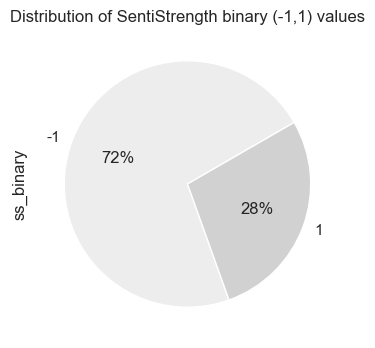

In [26]:
plt.figure(figsize=(4,4))
sns.set(style='white', palette='Greys', font_scale=1.0)

df['ss_binary'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%',
                                          startangle=30, 
                                          title='Distribution of SentiStrength binary (-1,1) values')

# count values of each label type
df['ss_binary'].value_counts()

-1    4941
 0     895
 1     793
Name: ss_trinary, dtype: int64

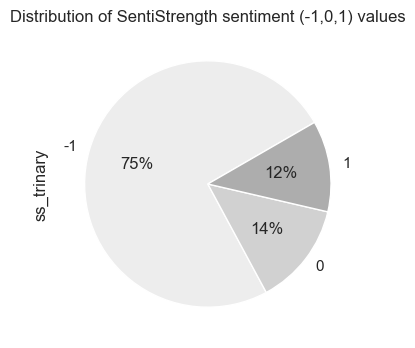

In [27]:
plt.figure(figsize=(4,4))
sns.set(style='white', palette='Greys', font_scale=1.0)

df['ss_trinary'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%',
                                          startangle=30, 
                                          title='Distribution of SentiStrength sentiment (-1,0,1) values')

# count values of each label type
df['ss_trinary'].value_counts()

-4    3077
 0    1126
-1     593
-2     534
-3     506
 1     368
 3     206
 2     159
 4      60
Name: ss_scale, dtype: int64

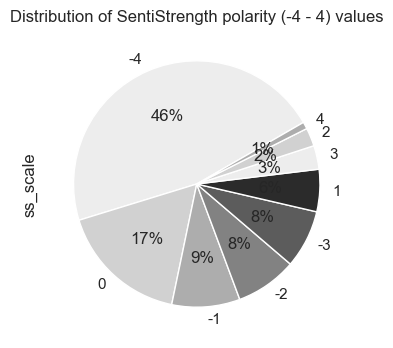

In [28]:
plt.figure(figsize=(4,4))
sns.set(style='white', palette='Greys', font_scale=1.0)

df['ss_scale'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%',
                                          startangle=30, 
                                          title='Distribution of SentiStrength polarity (-4 - 4) values')

# count values of each label type
df['ss_scale'].value_counts()

## Results analysis for binary sentiment values

In [29]:
# change sentiment values to binary
df['sent_binary'] = df['sentiment']
df['sent_binary'] = df['sent_binary'].replace(0, 1)
df['sent_binary'] = df['sent_binary'].replace(1, 1)
df['sent_binary'] = df['sent_binary'].replace(-1, -1)
df.head(50)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sampleLemmas,correctLemmas,sample_tokens,correct_tokens,sampleEmojis,correctEmojis,ss_binary,ss_trinary,ss_scale,sent_binary
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,-1,-1,0,-1
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...",-1,-1,-2,-1
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,--´973´¤-.ttu,973 vittu,--´973´¤-.ttu,973 vittu,--´973´¤-.ttu,973 vittu,-1,-1,-4,-1
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,-=>Widdu joo<= -,-= > vittu joo < = -,-=>widdu joo<= -,-= > vittu joo < = -,-=>widdu joo<= -,-= > vittu joo < = -,-1,-1,-3,-1
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...",-1,-1,-1,-1
5,6,- ei viddu -,-1,-5,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,...,- ei viddu -,ei vittu,- ei viddu -,ei vittu,- ei viddu -,ei vittu,-1,-1,-1,-1
6,7,- Huvittunut -,1,1,0,0,NaN,NaN,NaN,JOY,...,- huvittunut -,huvittua,- huvittunut -,huvittua,- huvittunut -,huvittua,1,1,1,1
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",-1,-4,1,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL",...,"- hyvä että joku nähdä uusi , tyhmä veroperust...","hyvä että joku nähdä uusi , tyhmä veroperuste ...","- hyvä että joku nähdä uusi , tyhmä veroperust...","hyvä että joku nähdä uusi , tyhmä veroperuste ...","- hyvä että joku nähdä uusi , tyhmä veroperust...","hyvä että joku nähdä uusi , tyhmä veroperuste ...",-1,-1,-4,-1
8,9,- Kukaan luterilainen ei korota itseään hänen ...,-1,-2,0,0,NaN,NaN,NaN,SADNESS,...,- kukaan luterilainen ei korottaa itse hän suh...,kukaan luterilainen ei korottaa itse hän suhde...,- kukaan luterilainen ei korottaa itse hän suh...,kukaan luterilainen ei korottaa itse hän suhde...,- kukaan luterilainen ei korottaa itse hän suh...,kukaan luterilainen ei korottaa itse hän suhde...,-1,-1,-3,-1
9,10,- kuten on sovittu -,0,0,0,0,NaN,NaN,NaN,NEUTRAL NONE,...,- kuten olla sopia -,kuten olla sopia,- kuten olla sopia -,kuten olla sopia,- kuten olla sopia -,kuten olla sopia,1,1,2,1


In [30]:
# count values of each label type
df['sent_binary'].value_counts()

-1    5336
 1    1293
Name: sent_binary, dtype: int64

In [31]:
# count values of each label type
df['ss_binary'].value_counts()

-1    4782
 1    1847
Name: ss_binary, dtype: int64

In [32]:
# create panda dataframe for results
df_ss_binary_results = pd.DataFrame({'sample':df['sample'], 'sentiment':df['sent_binary'], 'prediction':df['ss_binary']})
df_ss_binary_results

,sample,sentiment,prediction
0,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1
1,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-1
2,--´973´¤-.ttu,-1,-1
3,-=>Widdu joo<=-,-1,-1
4,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-1
...,...,...,...
6624,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,1
6625,😠👉👩‍💼,-1,1
6626,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,1
6627,🤮😡,-1,1


In [33]:
df_ss_binary_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6629 entries, 0 to 6628
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sample      6629 non-null   object
 1   sentiment   6629 non-null   int64 
 2   prediction  6629 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 155.5+ KB


In [34]:
sentiments = df_ss_binary_results['sentiment'].tolist()
predictions = df_ss_binary_results['prediction'].tolist()

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['negative', 'positive']

print(classification_report(sentiments, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

    negative       0.92      0.83      0.87      5336
    positive       0.50      0.71      0.58      1293

    accuracy                           0.80      6629
   macro avg       0.71      0.77      0.73      6629
weighted avg       0.84      0.80      0.81      6629



In [36]:
print(confusion_matrix(sentiments, predictions))

[[4406  930]
 [ 376  917]]


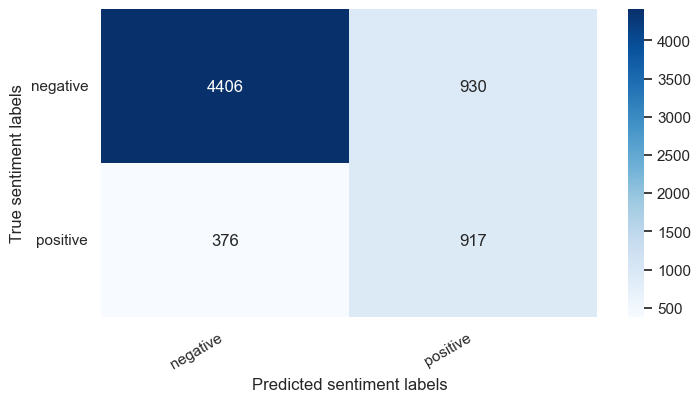

In [37]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment labels')
    plt.xlabel('Predicted sentiment labels');

cm = confusion_matrix(sentiments, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [38]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate accuracy
total_accuracy = accuracy_score(sentiments, predictions, normalize=True, sample_weight=None)
print('Accuracy  ', total_accuracy)

# calculate f1
total_f1 = f1_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('F1  ', total_f1)

# calculate precision
total_precision = precision_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Precision  ', total_precision)

# calculate recall
total_recall = recall_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Recall  ', total_recall)

Accuracy   0.8029868758485442
F1   0.8149730771997055
Precision   0.838495946801714
Recall   0.8029868758485442


In [39]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=sentiments, predict_vector=predictions)
cm.classes

[-1, 1]

In [40]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.80299
F1 Macro                                                          0.7275
FPR Macro                                                         0.23254
Kappa                                                             0.46021
NPV Macro                                                         0.70893
Overall ACC                                                       0.80299
PPV Macro                                                         0.70893
SOA1(Landis & Koch)                                               Moderate
TPR Macro                                                         0.76746
Zero-one Loss                                                     1306

Class Statistics :

Classes                                                           -1            1             
ACC(Accuracy)                                                     0.80299       0.80299       
AUC(Area under the ROC curve)

## Results analysis for trinary sentiment values

In [41]:
# create panda dataframe for results
df_ss_trinary_results = pd.DataFrame({'sample':df['sample'], 'sentiment':df['sentiment'], 'prediction':df['ss_trinary']})
df_ss_trinary_results

,sample,sentiment,prediction
0,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1
1,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-1
2,--´973´¤-.ttu,-1,-1
3,-=>Widdu joo<=-,-1,-1
4,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-1
...,...,...,...
6624,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,0
6625,😠👉👩‍💼,-1,0
6626,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,0
6627,🤮😡,-1,0


In [42]:
df_ss_trinary_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6629 entries, 0 to 6628
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sample      6629 non-null   object
 1   sentiment   6629 non-null   int64 
 2   prediction  6629 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 155.5+ KB


In [43]:
sentiments = df_ss_trinary_results['sentiment'].tolist()
predictions = df_ss_trinary_results['prediction'].tolist()

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['negative', 'neutral', 'positive']

print(classification_report(sentiments, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

    negative       0.91      0.85      0.88      5336
     neutral       0.21      0.30      0.25       639
    positive       0.55      0.67      0.61       654

    accuracy                           0.78      6629
   macro avg       0.56      0.61      0.58      6629
weighted avg       0.81      0.78      0.79      6629



In [45]:
print(confusion_matrix(sentiments, predictions))

[[4514  605  217]
 [ 309  192  138]
 [ 118   98  438]]


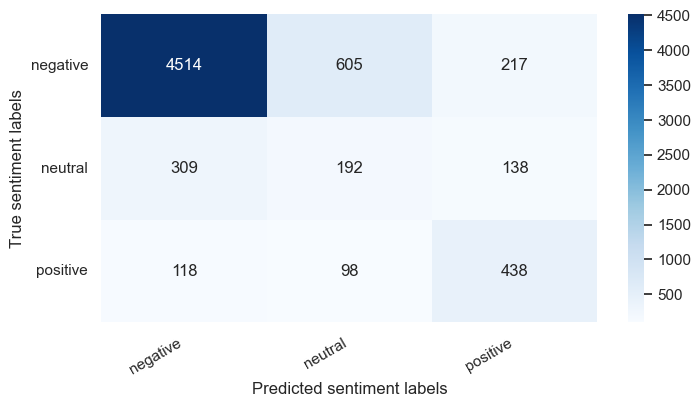

In [46]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment labels')
    plt.xlabel('Predicted sentiment labels');

cm = confusion_matrix(sentiments, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [47]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate accuracy
total_accuracy = accuracy_score(sentiments, predictions, normalize=True, sample_weight=None)
print('Accuracy  ', total_accuracy)

# calculate f1
total_f1 = f1_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('F1  ', total_f1)

# calculate precision
total_precision = precision_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Precision  ', total_precision)

# calculate recall
total_recall = recall_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Recall  ', total_recall)

Accuracy   0.7759843113591793
F1   0.7909761308404369
Precision   0.8105553608193169
Recall   0.7759843113591793


In [48]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=sentiments, predict_vector=predictions)
cm.classes

[-1, 0, 1]

In [49]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.85066
F1 Macro                                                          0.57806
FPR Macro                                                         0.16901
Kappa                                                             0.40295
NPV Macro                                                         0.79936
Overall ACC                                                       0.77598
PPV Macro                                                         0.56015
SOA1(Landis & Koch)                                               Moderate
TPR Macro                                                         0.60538
Zero-one Loss                                                     1485

Class Statistics :

Classes                                                           -1            0             1             
ACC(Accuracy)                                                     0.81159       0.82652       0.91386       


## Results analysis - for polarity values

In [50]:
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sampleLemmas,correctLemmas,sample_tokens,correct_tokens,sampleEmojis,correctEmojis,ss_binary,ss_trinary,ss_scale,sent_binary
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,-1,-1,0,-1
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...",-1,-1,-2,-1
2,3,--´973´¤-.ttu,-1,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,--´973´¤-.ttu,973 vittu,--´973´¤-.ttu,973 vittu,--´973´¤-.ttu,973 vittu,-1,-1,-4,-1
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,-=>Widdu joo<= -,-= > vittu joo < = -,-=>widdu joo<= -,-= > vittu joo < = -,-=>widdu joo<= -,-= > vittu joo < = -,-1,-1,-3,-1
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...",-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,5,0,0,NaN,NaN,NaN,JOY,...,😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,😂 😂 😂 😂 😂,😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,😂 😂 😂 😂 😂,:face_with_tears_of_joy: :face_with_tears_of_j...,:face_with_tears_of_joy: :face_with_tears_of_j...,1,0,0,1
6625,6626,😠👉👩‍💼,-1,-3,0,0,NaN,NaN,NaN,ANGER HATE,...,😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,:angry_face: :backhand_index_pointing_right: :...,:angry_face: :backhand_index_pointing_right: :...,1,0,0,-1
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,5,0,0,NaN,NaN,NaN,JOY,...,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,:rolling_on_the_floor_laughing: :rolling_on_th...,:rolling_on_the_floor_laughing: :rolling_on_th...,1,0,0,1
6627,6628,🤮😡,-1,-4,0,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",...,🤮 😡,🤮 😡,🤮 😡,🤮 😡,:face_vomiting: :enraged_face:,:face_vomiting: :enraged_face:,1,0,0,-1


In [51]:
# change sentiment values
df['polarity'] = df['polarity'].replace(-5, -4)
df['polarity'] = df['polarity'].replace(5, 4)
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sampleLemmas,correctLemmas,sample_tokens,correct_tokens,sampleEmojis,correctEmojis,ss_binary,ss_trinary,ss_scale,sent_binary
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,-1,-1,0,-1
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...",-1,-1,-2,-1
2,3,--´973´¤-.ttu,-1,-4,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,--´973´¤-.ttu,973 vittu,--´973´¤-.ttu,973 vittu,--´973´¤-.ttu,973 vittu,-1,-1,-4,-1
3,4,-=>Widdu joo<=-,-1,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,-=>Widdu joo<= -,-= > vittu joo < = -,-=>widdu joo<= -,-= > vittu joo < = -,-=>widdu joo<= -,-= > vittu joo < = -,-1,-1,-3,-1
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-4,0,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...",-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,4,0,0,NaN,NaN,NaN,JOY,...,😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,😂 😂 😂 😂 😂,😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,😂 😂 😂 😂 😂,:face_with_tears_of_joy: :face_with_tears_of_j...,:face_with_tears_of_joy: :face_with_tears_of_j...,1,0,0,1
6625,6626,😠👉👩‍💼,-1,-3,0,0,NaN,NaN,NaN,ANGER HATE,...,😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,:angry_face: :backhand_index_pointing_right: :...,:angry_face: :backhand_index_pointing_right: :...,1,0,0,-1
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,4,0,0,NaN,NaN,NaN,JOY,...,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,:rolling_on_the_floor_laughing: :rolling_on_th...,:rolling_on_the_floor_laughing: :rolling_on_th...,1,0,0,1
6627,6628,🤮😡,-1,-4,0,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",...,🤮 😡,🤮 😡,🤮 😡,🤮 😡,:face_vomiting: :enraged_face:,:face_vomiting: :enraged_face:,1,0,0,-1


In [52]:
# create panda dataframe for results
df_polarity_results = pd.DataFrame({'sample':df['sample'], 'polarity':df['polarity'], 'prediction':df['ss_scale']})
df_polarity_results

,sample,polarity,prediction
0,- Ajatus siitä että kaikki henkilön tienaamat...,-1,0
1,"- Kaivovertauksessa, viime hallitus on kaivan...",-2,-2
2,--´973´¤-.ttu,-4,-4
3,-=>Widdu joo<=-,-4,-3
4,"- Ei , mutta olen joutunut elämään katsomalla ...",-4,-1
...,...,...,...
6624,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,4,0
6625,😠👉👩‍💼,-3,0
6626,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,4,0
6627,🤮😡,-4,0


In [53]:
sentiments = df_polarity_results['polarity'].tolist()
predictions = df_polarity_results['prediction'].tolist()

In [54]:
# count values of each label type
df['polarity'].value_counts()

-4    3948
-3     797
 0     565
-2     431
 4     303
-1     218
 3     137
 2     135
 1      95
Name: polarity, dtype: int64

In [55]:
# count values of each label type
df['ss_scale'].value_counts()

-4    3077
 0    1126
-1     593
-2     534
-3     506
 1     368
 3     206
 2     159
 4      60
Name: ss_scale, dtype: int64

In [56]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['-4', '-3', '-2', '-1', '0', '1', '2', '3', '4']

print(classification_report(sentiments, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

          -4       0.86      0.67      0.75      3948
          -3       0.17      0.11      0.13       797
          -2       0.12      0.15      0.13       431
          -1       0.07      0.18      0.10       218
           0       0.20      0.41      0.27       565
           1       0.09      0.36      0.15        95
           2       0.10      0.12      0.11       135
           3       0.12      0.18      0.15       137
           4       0.67      0.13      0.22       303

    accuracy                           0.48      6629
   macro avg       0.27      0.26      0.22      6629
weighted avg       0.59      0.48      0.51      6629



In [57]:
print(confusion_matrix(sentiments, predictions))

[[2632  301  279  260  395   61   16    4    0]
 [ 267   87   93  107  188   37   11    6    1]
 [  97   37   63   71  116   32    9    5    1]
 [  22   30   27   39   67   20    5    7    1]
 [  41   36   56   78  229   69   36   17    3]
 [   1    3    4    5   25   34   11   11    1]
 [   1    4    5   14   29   38   16   23    5]
 [   8    5    4   10   34   25   18   25    8]
 [   8    3    3    9   43   52   37  108   40]]


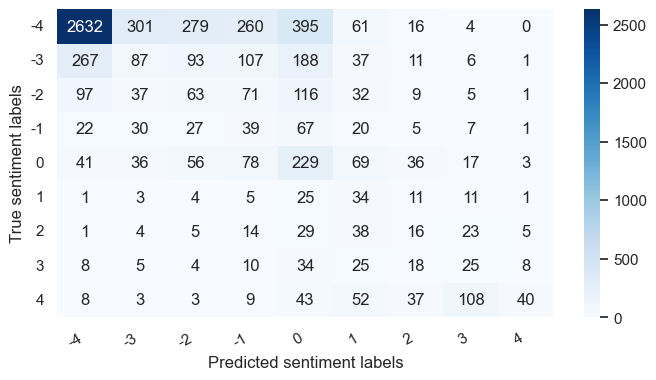

In [58]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment labels')
    plt.xlabel('Predicted sentiment labels');

cm = confusion_matrix(sentiments, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [59]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate accuracy
total_accuracy = accuracy_score(sentiments, predictions, normalize=True, sample_weight=None)
print('Accuracy  ', total_accuracy)

# calculate f1
total_f1 = f1_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('F1  ', total_f1)

# calculate precision
total_precision = precision_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Precision  ', total_precision)

# calculate recall
total_recall = recall_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Recall  ', total_recall)

Accuracy   0.4774475788203349
F1   0.5144704370528294
Precision   0.5936263382750187
Recall   0.4774475788203349


In [60]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=sentiments, predict_vector=predictions)
cm.classes

[-4, -3, -2, -1, 0, 1, 2, 3, 4]

In [61]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.88388
F1 Macro                                                          0.22248
FPR Macro                                                         0.07248
Kappa                                                             0.242
NPV Macro                                                         0.91965
Overall ACC                                                       0.47745
PPV Macro                                                         0.26616
SOA1(Landis & Koch)                                               Fair
TPR Macro                                                         0.25523
Zero-one Loss                                                     3464

Class Statistics :

Classes                                                           -4            -3            -2            -1            0             1             2             3             4             
ACC(Accuracy)                  